<a href="https://colab.research.google.com/github/Alro10/time-series-statistical-tests/blob/master/statistical_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical tests for Time Series - Using Climatic Data for COVID-19 analysis

In [1]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline
# based on https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python#Topic-9.-Part-1.-Time-series-analysis-in-Python

## Stationarity test

**Augmented Dickey-Fuller test (ADF)**

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

- Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.

p-value > 0.05: Accept H0, the data has a unit root and is non-stationary

p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary


## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

## Dataset

In [66]:
capitals_df = pd.read_csv('all_capitals_climate.csv', index_col=['validdate'])

ads = capitals_df

In [67]:
ads.rename(columns={'Unnamed: 0': 'city'}, inplace=True)
ads.drop(['Unnamed: 1'], axis=1, inplace=True)
ads = ads[ads['city'] == 'Teresina']
ads = ads[['t_2m:C']]
ads.rename(columns={'t_2m:C':'Ads'}, inplace=True)

In [68]:
# currency.head()
ads.head()

,Ads
validdate,
2020-01-01T00:00:00Z,11.3
2020-01-02T00:00:00Z,10.7
2020-01-03T00:00:00Z,10.6
2020-01-04T00:00:00Z,8.8
2020-01-05T00:00:00Z,11.1


### Plots

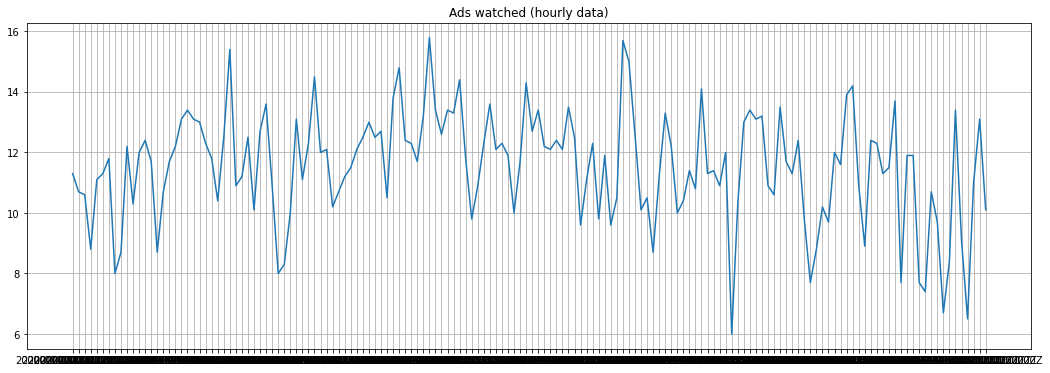

In [69]:
plt.figure(figsize=(18, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [70]:
# plt.figure(figsize=(18, 6))
# plt.plot(currency.GEMS_GEMS_SPENT)
# plt.title('In-game currency spent (daily data)')
# plt.grid(True)
# plt.show()

## Moving average, metrics and so on
Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like  $\hat{y}_t=y_t−1$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use ***the moving average.***

\begin{equation}
\hat{y}_{t}=\frac{1}{k} \sum_{n=1}^{k} y_{t-n}
\end{equation}

In [71]:
# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """This function calculates moving average and plots with confidence intervals

        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """

    rolling_mean = series.rolling(window=window).mean()
    rollig_std = series.rolling(window=window).std()

    plt.figure(figsize=(18,6))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="best")
    plt.grid(True)

    
def getAnomaliesList(series, window):

    """This function calculates moving average and plots with confidence intervals

        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
    """
    scale=1.96
    listAnomalies = []

    rolling_mean = series.rolling(window=window).mean()
    rollig_std = series.rolling(window=window).std()

    # Plot confidence intervals for smoothed values

    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
        
    # Having the intervals, find abnormal values

    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
            
    listAnomalies = anomalies

    return listAnomalies
    
    
def test_adfuller(series):
  
    """Augmented Dickey-Fuller test (ADF)

       p-value > 0.05: Accept H0, the data has a unit root and is non-stationary

       p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary  
    """

    series = series.values
    result = sm.tsa.stattools.adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))    

In [72]:
test_adfuller(ads.Ads)

ADF Statistic: -5.322615
p-value: 0.000005
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


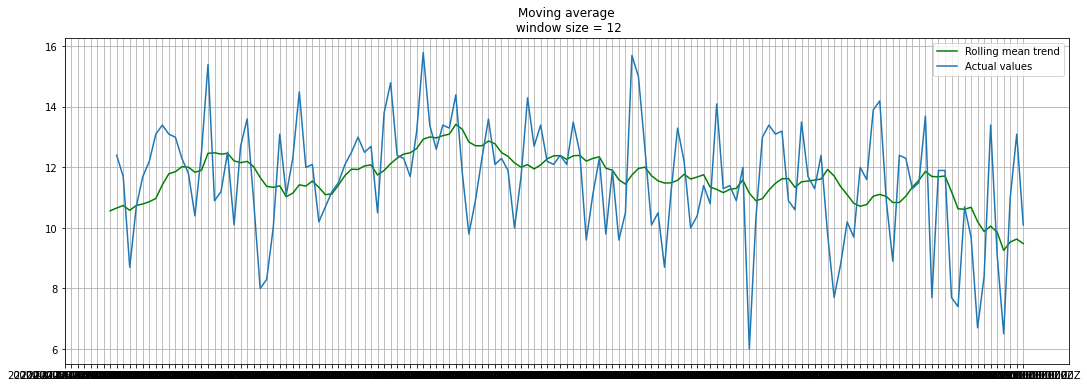

In [73]:
plotMovingAverage(ads, 12) # Let's smooth by the previous 12 hours

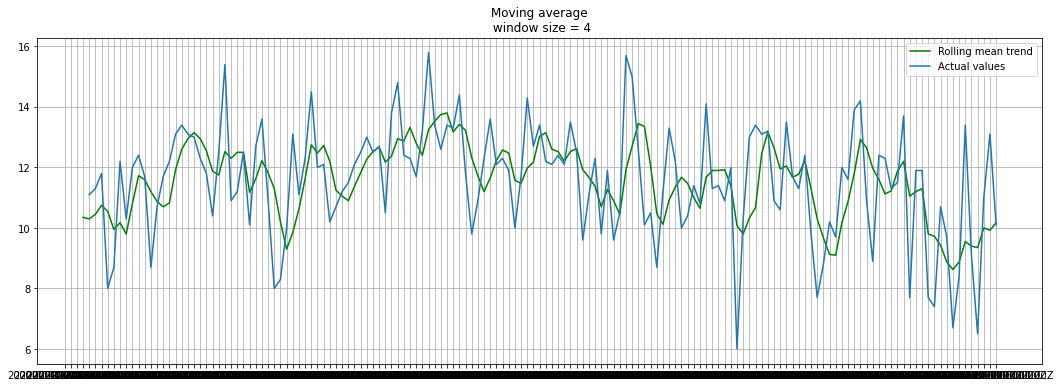

In [74]:
plotMovingAverage(ads, 4) # Let's smooth by the previous 4 hours

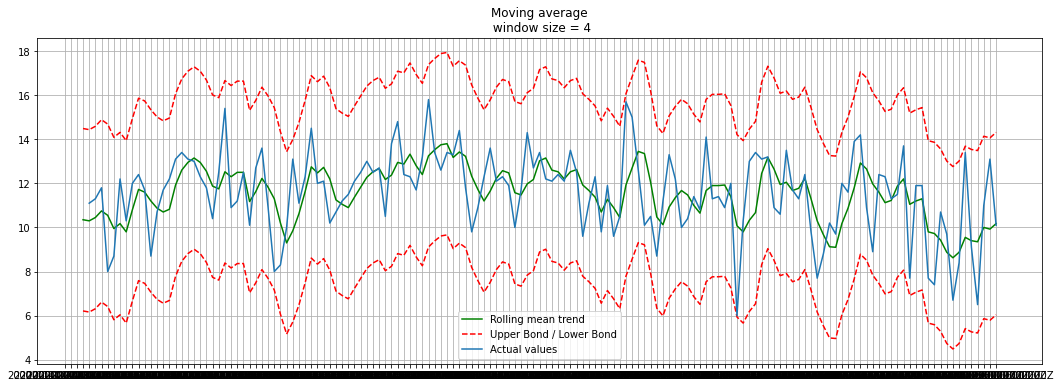

In [75]:
plotMovingAverage(ads, 4, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe ads_anomaly.

In [76]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

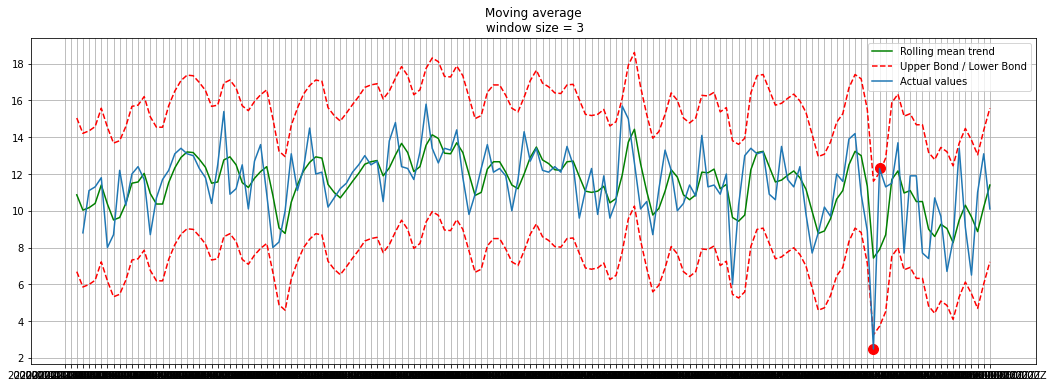

In [77]:
# Let see if the simple method can catch the anomaly
plotMovingAverage(ads_anomaly, 3, plot_intervals=True, plot_anomalies=True)

In [128]:
anomaly_points = {}

In [133]:
capitals_df = pd.read_csv('all_capitals_climate.csv', index_col=['validdate'])
capitals_df.rename(columns={'Unnamed: 0': 'city', 't_2m:C': 'temp', 'relative_humidity_2m:p': 'humid',
                            'precip_1h:mm': 'prec'}, inplace=True)
capitals_df.drop(['Unnamed: 1'], axis=1, inplace=True)
capital_names = capitals_df.city.unique()

for item in capital_names:
    
    ads = capitals_df.copy()
    ads = ads[ads['city'] == item]
    
    feature = 'humid'

    ads = ads[[feature]]
    ads.rename(columns={feature:'Ads'}, inplace=True)
    
    ads_anomaly = ads.copy()
    ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2

    anomalies_results = getAnomaliesList(ads_anomaly, 4)
    anomalies_values = anomalies_results['Ads'].values

    anomalies_indexes = []

    for i, value in enumerate(anomalies_values):
        if not math.isnan(value):
            anomalies_indexes.append(i)
    
    if not anomaly_points.get(item):
        anomaly_points[item] = {}
    anomaly_points[item]['anomalous_points_'+feature] = anomalies_indexes
    anomaly_points[item]['timeseries_'+feature] = capitals_df[capitals_df.city == item][feature].values.tolist()
    
# saving processed data in json format
import json
with open('anomaly_'+feature+'_points.json', 'w', encoding='utf8') as file:
    json.dump(anomaly_points, file, ensure_ascii=False)

In [116]:
similarity_series = {}

for item1 in capital_names:
    ads = capitals_df.copy()
    city1 = ads[ads['city'] == item1]
    
    similarity_series[item1] = {}
    
    for item2 in capital_names:
        ads = capitals_df.copy()
        city2 = ads[ads['city'] == item2]
        
        similarity_series[item1][item2] = {}
        
        list_features = ['temp', 'humid', 'prec']
        
        for feature in list_features:
            
            # Calculate euclidean distance to get similatiry between the timeseries
            from sklearn.metrics.pairwise import cosine_similarity
            
            distance = cosine_similarity(city1[feature].values.reshape(1, -1), city2[feature].values.reshape(1, -1))
            distance = distance[0][0] if distance[0][0] > 0 else 0.01
            
            similarity_series[item1][item2]['similarity_' + feature] = float(f"{distance:.2f}")        


# saving processed data in json format
import json
with open('climatic_similarity.json', 'w', encoding='utf8') as file:
    json.dump(similarity_series, file, ensure_ascii=False)

In [117]:
similarity_series

{'Rio Branco': {'Rio Branco': {'similarity_temp': 1.0,
   'similarity_humid': 1.0,
   'similarity_prec': 1.0},
  'Maceió': {'similarity_temp': 0.01,
   'similarity_humid': 0.98,
   'similarity_prec': 0.12},
  'Macapá': {'similarity_temp': 0.01,
   'similarity_humid': 0.99,
   'similarity_prec': 0.14},
  'Manaus': {'similarity_temp': 0.8,
   'similarity_humid': 0.99,
   'similarity_prec': 0.28},
  'Salvador': {'similarity_temp': 0.01,
   'similarity_humid': 0.98,
   'similarity_prec': 0.1},
  'Fortaleza': {'similarity_temp': 0.01,
   'similarity_humid': 0.98,
   'similarity_prec': 0.05},
  'Brasília': {'similarity_temp': 0.01,
   'similarity_humid': 0.99,
   'similarity_prec': 0.34},
  'Vitória': {'similarity_temp': 0.01,
   'similarity_humid': 0.99,
   'similarity_prec': 0.15},
  'Goiânia': {'similarity_temp': 0.01,
   'similarity_humid': 0.99,
   'similarity_prec': 0.34},
  'São Luís': {'similarity_temp': 0.01,
   'similarity_humid': 0.98,
   'similarity_prec': 0.11},
  'Cuiabá': {'si

[15.6,
 14.1,
 16.2,
 11.9,
 14.2,
 14.1,
 14.9,
 12.5,
 11.3,
 15.1,
 14.5,
 14.7,
 15.1,
 16.5,
 14.2,
 12.8,
 13.7,
 14.0,
 14.9,
 15.4,
 14.7,
 14.7,
 16.0,
 17.4,
 14.0,
 13.2,
 16.5,
 17.4,
 16.1,
 17.4,
 14.2,
 15.9,
 18.3,
 15.7,
 15.0,
 12.1,
 11.6,
 14.9,
 16.6,
 16.2,
 16.8,
 17.8,
 14.8,
 13.0,
 12.6,
 13.2,
 14.2,
 14.5,
 16.0,
 15.9,
 15.4,
 16.8,
 14.9,
 15.3,
 16.0,
 16.9,
 14.1,
 15.3,
 16.3,
 17.1,
 18.0,
 16.9,
 16.9,
 16.1,
 17.0,
 17.9,
 14.4,
 13.7,
 16.1,
 17.9,
 14.8,
 15.3,
 14.9,
 13.7,
 14.5,
 17.4,
 15.4,
 16.8,
 15.7,
 15.4,
 16.1,
 15.6,
 18.7,
 15.9,
 13.8,
 14.9,
 16.0,
 14.2,
 14.9,
 15.4,
 12.3,
 17.4,
 18.2,
 14.0,
 15.5,
 12.7,
 13.0,
 16.3,
 16.7,
 15.5,
 15.3,
 13.2,
 13.6,
 14.1,
 16.2,
 14.4,
 15.1,
 13.8,
 17.6,
 11.4,
 11.2,
 15.3,
 15.2,
 15.5,
 16.2,
 15.2,
 11.9,
 14.7,
 16.1,
 14.1,
 14.5,
 15.2,
 11.6,
 13.0,
 15.3,
 16.5,
 16.8,
 13.8,
 15.5,
 17.2,
 13.0,
 12.4,
 13.2,
 14.1,
 14.8,
 12.8,
 16.4,
 13.6,
 13.4,
 16.3,
 11.9,
 10.2,
 14.2,